### Intuition behind approach:
* The essence to properly do the one class classification on this dataset is to learn the underlying sequence strcture of the names
* The sequence can be learnt by approximating what letters occur in Hindi Names
* But that is not much useful as english letters are in total 26 and most of the languages and their words around the world can be represented in english
* This brings to an important observation:
    - We can learn the combination of letters that are there in names
    - These combinations of one language might be different from another language names
    - If we can properly learn mappings (vectors) of tokens(token : combinations of letters) of names that belongs to a particular language
    , then we can represent each name ( a sum of such combinations) as a vector too.
    - These vectors can then be fed to our classifier for modelling. 
* Evaluations:
    - For evalation I can use False Positive rate for negative_class files.
    - I can also use accuracy as a metric if I mix some instances of target calss with outlier class.
    
<br/>
** PS: In this model I have used tokens and ngram interchangable. In the next approach of word2vec I make the distinction between them. **

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
data=pd.read_table('hindu_baby_names.txt',sep='\n',names=['Names'])

In [11]:
data.head()

,Names
0,aabha
1,aabharan
2,aabheer
3,aachman
4,or puja


In [12]:
data['Names'].isnull().values.any()

False

#### Split data in training and testing
    

* Since I already have very less data for training
* I will keep very less part for testing from target data set
* Will test on other testing data provided.

In [13]:
#Making a copy of data to test
dataCopy=data.copy()

In [14]:
#Split Size is the percentage of data in training set
def splitData(dataCopy,splitSize):
    trainData=[]
    testData=[]
    trainNames=dataCopy[:int(.01*splitSize*len(dataCopy))]
    testNames=dataCopy[len(trainNames):]
    
    for i in range(len(trainNames)):
        trainData.extend(trainNames.iloc[i])
    for i in range(len(testNames)):
        testData.extend(testNames.iloc[i])
        
    print("Number of names in training Set: "+str(len(trainData)))
    print("Number of names in test Set: "+str(len(testData)))
    return trainData,testData

#### Form test Set 

* following code will be used to join names in the other two files provided with the names
in the test set of the target class

In [15]:
df1=pd.read_table('negative_class_1.txt',sep='\n',names=['Names'])
df2=pd.read_table('negative_class_2.txt',sep='\n',names=['Names'])

In [16]:
df1=df1.append(df2,ignore_index=True)

In [17]:
testFilesCorpus=[]
for i in range(len(df1)):
    word=df1.iloc[i]
    testFilesCorpus.extend(word)

In [19]:
print("Total names for testing: " + str(len(testFilesCorpus)))

Total names for testing: 8554


#### Clean the names from common punctuation and chosen noisy words

* For proper learning and catching tokens that are actually there in names we can remove the punctuations present
* We can also remove specific words that arent part of names but occur as a separate word alongwith the string

In [29]:
def cleanText(t):
    return ''.join(l.strip(',."!?;:()/\'') for l in t)

def removeNoisyWords(text):
    stopList=set('or a the and it is if to in for of'.split())
    result=[]
    for name in text:
        words=name.lower().split()
        temp=[]
        for i in words:
            if i not in stopList:
                temp.extend(i)
        result.append(temp)   
    return result

In [30]:
trainNames,testNames=splitData(dataCopy,90)

Number of names in training Set: 7371
Number of names in test Set: 819


In [31]:
trainNames[:5]

['aabha', 'aabharan', 'aabheer', 'aachman', 'or puja']

In [32]:
trainNames=removeNoisyWords(trainNames)
trainNames=[cleanText(n) for n in trainNames]

In [33]:
trainNames[:5]

['aabha', 'aabharan', 'aabheer', 'aachman', 'puja']

In [34]:
#The total Names in the corpus
totalNames=trainNames+testNames


#### Creating Tokens of n letters of each names

* This function divided each name into combinations of n letters each
* Sometimes referred to as ngram 
* I will try to test with n=2 and n=3
* This is done because the essence of learning names or words from a particular 
language, we can look into combination of letters occuring right next to each other.
Such combinations of letters are unique to each language. For example, in name "aditya"
the letter combinations "it" and "ty" are maybe unique to Hindi Language and rare in 
names of other Languages.

In [35]:
def generateTokens(text,n):
    letters=text
    output=[]
    for i in range(len(letters)-n+1):
        output.append(letters[i:i+n])
    return output

In [36]:
class text:
    def __init__(self,data,tokenSize=2):
        self.data=[]
        for name in data:
            self.data.extend(generateTokens(name.lower(),tokenSize))
        self.tokenSize=tokenSize


#### Create a Mapping of all unique tokens

* Creating a list which contains unique tokens in the entire corpus of names
* This list will provide us a mapping of index -> token
* Using this list, a input vector of the size of this list for each name can be created.

In [37]:
def createList(data):
    s=set(data)
    lst=list(s)
    return lst

def createToken2Index(data):
    token2Index={}
    lst=createList(data)
    for index,token in enumerate(lst):
        token2Index[token]=index
    return token2Index


#### Generate one hot embeddings for each name in trainData

* Each name is allotted a vector of size same as the list created in last portion
* This vector will represent the feature set of each name in the corpus
* For each token in a name, the index of that token can be set 
* Thus, a feature set of name contains a set bit at the index of its token and 0 otherwise

In [38]:
def createTokenVector(data,tokenSize,token2Index):
    trainVector=[]
    for name in data:
        tokens=generateTokens(name,tokenSize)
        vector=np.zeros((len(token2Index.keys(),)))
        for i in tokens:
            if i in token2Index:
                index=token2Index[i]
                vector[index]=1
        trainVector.append([name,vector])
    return pd.DataFrame(trainVector)

#function to create the feature set of the names
def getFeatureSet(data,tokenSize,token2Index):
    rowList=[]
    textDF=createTokenVector(data,tokenSize,token2Index)
    for i in range(len(textDF)):
        row=textDF.iloc[i][1]
        rowList.append(row)
    featureSet=pd.DataFrame(rowList)
    return featureSet

#### Visualizing Embeddings in 2d space using PCA

* Trying to check which names are closer when the dimensionality is reduced to two
* This graph provides an intuition as to how names are placed on the basis of similarity of the feature set we have created

In [115]:
from sklearn.decomposition import PCA
import seaborn as sns

In [125]:
def visualizePCA(df,names):
    #using 2 components for PCA to visualize in 2 dimension
    pca=PCA(n_components=2)
    result=pca.fit_transform(df)
    plt.scatter(result[:,0],result[:,1],alpha=.2)
    for i in range(0,len(names),100):
        name=names[i]
        plt.annotate(name,xy=(result[i,0],result[i,1]))
    plt.title("Model 2-d Visualization")
    plt.show()

* The following function plots training and validation curve for an estimator.
* The plots are done by varying a single param with a range provided explicitly 

In [42]:
def plotValidationCurve(estimator,title,X,y,param,param_range,cv=None,scoring="accuracy",n_jobs=1):
    train_scores, test_scores = validation_curve(
    estimator, X, y, param_name=param, param_range=param_range,
    cv=cv, scoring=scoring, n_jobs=n_jobs)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross Validation score",
             color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

* The following plot plots learning curve for an estimator
* The training and validation errors are plotted for the number of training examples 
represented on the x-axis

In [43]:
def plotLearningCurve(estimator,title,X,y,n_jobs=1,scoring="accuracy"):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel(scoring)
    train_sizes,train_scores,test_scores=learning_curve(estimator,
                                                    X,y,
                                                   n_jobs=2,scoring="accuracy")
    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)
    
    plt.fill_between(train_sizes,train_scores_mean-train_scores_std,
                    train_scores_mean+train_scores_std,alpha=0.1,color='g')
    
    plt.fill_between(train_sizes,test_scores_mean-test_scores_std,
                    test_scores_mean+test_scores_std,alpha=0.1,color='r')
    plt.plot(train_sizes,train_scores_mean,'o-',color='g',label="Training Score")
    plt.plot(train_sizes,test_scores_mean,'o-',color='r',label="Cross Validation Score")
    plt.legend(loc="best")
    return plt

### 2gram Model

In [44]:
#training Names
print(trainNames[:5])
print("Length of training data: "+str(len(trainNames)))

['aabha', 'aabharan', 'aabheer', 'aachman', 'puja']
Length of training data: 7371


In [45]:
#Form 2gram object of text class
trainNames2GramObj=text(trainNames,2)
print(trainNames2GramObj.data[:5])
print("Length of data in trainNames2GramObj: "+str(len(trainNames2GramObj.data)))

['aa', 'ab', 'bh', 'ha', 'aa']
Length of data in trainNames2GramObj: 47341


In [46]:
#Create token2Index mapping of unique tokens from trainNames2GramObj's data
token2Index2Gram=createToken2Index(trainNames2GramObj.data)
token2Index2Gram['aa']

256

In [47]:
#Get Feature Set of names in TrainNames
trainNames2GramFS=getFeatureSet(trainNames,trainNames2GramObj.tokenSize,token2Index2Gram)
print("Shape of feature set of trainNames: ",trainNames2GramFS.shape)

Shape of feature set of trainNames:  (7371, 428)


In [48]:
trainNames2GramTarget=[1 for _ in range(len(trainNames))]
print("Shape of Target label for trainNames Feature Set: ",len(trainNames2GramTarget))

Shape of Target label for trainNames Feature Set:  7371


* Now I have feature set of 7371 names with 428 features for each name

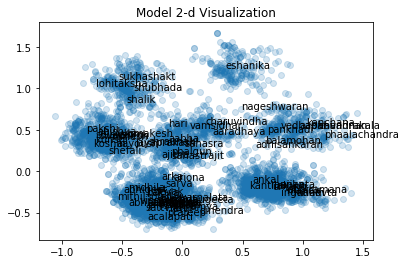

In [126]:
visualizePCA(trainNames2GramFS,trainNames)

* We can infer that there are  cluster of names that exist if 2grams are used
* Next I will create a oneClassSVM model from sklearn to train on this feature set

#### OneClassSVM
* This model assumes a hypersphere exists around the target data in the vector space of target class
* It tries to find the boundary of that hypersphere
* It is suitable for data set with very few instances as it has some bias
* If we had a huge dataset to train on then density estimation techniques would work better
* OneClassSvm is a boundary detection technique

In [60]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


* Trying out linear kernel classifier

In [51]:
linearSVM=OneClassSVM(kernel='linear',random_state=10)

<module 'matplotlib.pyplot' from 'C:\\Users\\Siddharth\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\matplotlib\\pyplot.py'>

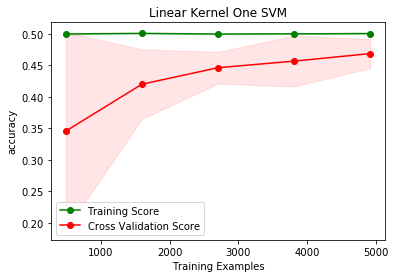

In [52]:
plotLearningCurve(linearSVM,"Linear Kernel One SVM",trainNames2GramFS,
                  trainNames2GramTarget,1,"accuracy")

In [53]:
plt.show()

##### Analysis:
* The training score is maintained at a level
* The cross validation score increases with number of instances
* This plot suggests that with more data, we could train our linear kernel SVM with
better accuracy

In [54]:
#Creating Feature set of test instances
testFilesCorpusFS=getFeatureSet(testFilesCorpus,trainNames2GramObj.tokenSize,token2Index2Gram)
testNamesFS=getFeatureSet(testNames,trainNames2GramObj.tokenSize,token2Index2Gram)
testNamesFS=testNamesFS.append(testFilesCorpusFS,ignore_index=True)

In [55]:
y1=[-1 for _ in range(len(testFilesCorpus))]
y2=[1 for _ in range(len(testNames))]
testNamesTarget=y2+y1   
print(testNamesTarget[:5],testNamesTarget[-5:])

[1, 1, 1, 1, 1] [-1, -1, -1, -1, -1]


In [56]:
# Plotting confusion matrix 

In [57]:
m=OneClassSVM(kernel="linear")
m.fit(trainNames2GramFS)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto',
      kernel='linear', max_iter=-1, nu=0.5, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

In [58]:
testError=m.predict(testNamesFS)

In [61]:
testErrorNegativeClass=m.predict(testFilesCorpusFS)
print("Accuracy Socre On Negative Class: ",accuracy_score(y1,testErrorNegativeClass))

Accuracy Socre On Negative Class:  0.965162497077


* We are able to classify outlier class with 96% accuracy as outliers
* This means we have very little False Positives and more True Negatives predicted
* Lets look at the confusion matrix of the total Test Set with some instances of target class present.

* Confusion Matrix

In [62]:
#This is the confusion matrix on the training set
confusion_matrix(testNamesTarget,testError)

array([[8256,  298],
       [ 597,  222]], dtype=int64)

* True Negatives count(True State: Outlier -> Predicted State: Outlier is at (0,0)
* False Negative Count (True State: Target -> Predicted State: Outlier is at (1,0)
* True Positive Count (True State: Target -> Predicted State: Target is at (1,1)
* False Postive Count (True State: Outlier -> Predicted State: Target is at (0,1)
* Accuracy : TP+TN/(TP+TN+FP+FN)
* False Positive Rate: FP/FP+TN
* Precision : TP/TP+FP 
* Recall : TP/TP+FN


#### Analysis
* We can see that the False Positive count is way low than that of the true negative
* This suggests that 2gram OneClass SVM is able to filter most part of the outlier class as outliers
* But the count of True positives is very less
* This maybe due to underfitting 
* Lets try using a polynomial kernel with default hyperparameters
* Accuracy : .90 -> Model gives good accuracy on mix of target and outliers
* FPR ~ .03 -> Model able to filter out most of the outliers
* Precision ~ 222/(222+298) = .42
* Recall ~ 222/819 = .27

In [63]:
polySVM=OneClassSVM(kernel='poly')

In [64]:
# Plotting confusion matrix 
polySVM.fit(trainNames2GramFS)
testError2=polySVM.predict(testNamesFS)
confusion_matrix(testNamesTarget,testError2)

array([[8258,  296],
       [ 611,  208]], dtype=int64)

* This has nearly the same results as linear svm.
* this may be due to the training data being too sparse
* This may also be due to not being able to capture hidden sequence structure of the names
* Next I will try using three grams of names to check if 3grams is ideal than 2gram to capture the sequence structure
* Accuracy: .90 ~ Behaves well too
* FPR: .03 
* Precision ~ .41
* Recall ~ .25

### 3Gram Model

#### Intuition:
* Maybe taking bigger letter window of names to form tokens can help us catch better sequence structure

In [67]:
#Creating object of text class with total names and 3 as size of each gram
threeGramsObj=text(trainNames,3)

In [68]:
threeGramsObj.data[:5]

['aab', 'abh', 'bha', 'aab', 'abh']

In [69]:
#create dictionary of index to token
threeGram2Index=createToken2Index(threeGramsObj.data)

In [70]:
#Create feature set of all train names using this dictionary
trainNames3GramFS=getFeatureSet(trainNames,threeGramsObj.tokenSize,threeGram2Index)
trainNames3GramTarget=[1 for _ in range(len(trainNames))]

In [71]:
trainNames3GramFS.shape

(7371, 2666)

##### Analysis:
* The feature set for three gram model has increased
* The number of tokens is more
* This would result in a more sparse feature set

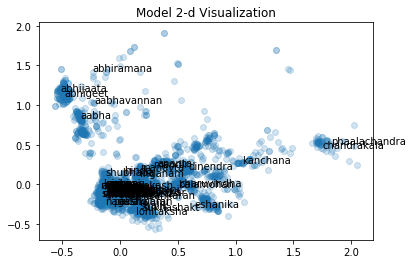

In [127]:
visualizePCA(trainNames3GramFS,trainNames)

* We can see that there are more number of dissimilar names here than 2grams
* This maybe due to more uniqueness in 3grams
* Names similar here are more strongly related 
* Though this increases more strong similarity, but the feature set is getting more sparse. 

In [73]:
#Trying Linear Kernel first
linearSVM3Gram=OneClassSVM(kernel='linear',random_state=10)

<module 'matplotlib.pyplot' from 'C:\\Users\\Siddharth\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\matplotlib\\pyplot.py'>

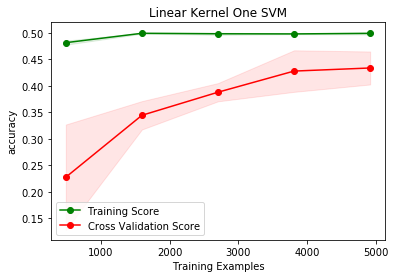

In [74]:
plotLearningCurve(linearSVM3Gram,"Linear Kernel One SVM",trainNames3GramFS,
                  trainNames3GramTarget,1,"accuracy")

In [75]:
plt.show()

In [76]:
#Creating Feature set of test instances
testFilesCorpusFS=getFeatureSet(testFilesCorpus,threeGramsObj.tokenSize,threeGram2Index)
testNamesFS=getFeatureSet(testNames,threeGramsObj.tokenSize,threeGram2Index)
testNamesFS=testNamesFS.append(testFilesCorpusFS,ignore_index=True)

In [77]:
y1=[-1 for _ in range(len(testFilesCorpus))]
y2=[1 for _ in range(len(testNames))]
testNamesTarget=y2+y1   
print(testNamesTarget[:5],testNamesTarget[-5:])

[1, 1, 1, 1, 1] [-1, -1, -1, -1, -1]


In [78]:
##### Plotting confusion matrix 
m3=OneClassSVM(kernel="linear")
m3.fit(trainNames3GramFS)
testError3=m3.predict(testNamesFS)

In [79]:
confusion_matrix(testNamesTarget,testError2)

array([[8258,  296],
       [ 611,  208]], dtype=int64)

* True Negatives count(True State: Outlier -> Predicted State: Outlier is at (0,0)
* False Negative Count (True State: Target -> Predicted State: Outlier is at (1,0)
* True Positive Count (True State: Target -> Predicted State: Target is at (1,1)
* False Postive Count (True State: Outlier -> Predicted State: Target is at (0,1)
* Accuracy : TP+TN/(TP+TN+FP+FN)
* False Positive Rate: FP/FP+TN
* Precision : TP/TP+FP 
* Recall : TP/TP+FN

#### Analysis
* We can see that the false Negative count has risen
* The False positive count is lower than linear of 2gram. This may be because the feature set is more sparse than the 2gram model
* Maybe using both 2gram and 3gram as features of the model will result in better feature set
* Accuracy: .90 -> Gives us pretty good accuracy
* FPR: .03 -> Most of the outlier instance are rejected
* Precision ~ .5
* Recall ~ .23
* Using 3Grams has helped increase the precision. This can be inferred as that this model lowers the positives. But the precision is increased by filtering out most of the outliers that were predicted as targets in earlier models.
* Maybe grid search will help to tune the parameters.

In [80]:
#PolySVM
polySVM=OneClassSVM(kernel='poly')
# Plotting confusion matrix 
polySVM.fit(trainNames3GramFS)
testError3=polySVM.predict(testNamesFS)
confusion_matrix(testNamesTarget,testError3)

array([[8320,  234],
       [ 635,  184]], dtype=int64)

###  2Grams and 3Grams combines Model

#### Intuition:
* In this approach, we take both 2grams and 3grams to form features of the names
* This may be helpful to catch better sequence structure
* But this may also produce more sparse matrix

In [82]:
#Separating more training data
trainN,testN=splitData(dataCopy,95)

Number of names in training Set: 7780
Number of names in test Set: 410


In [83]:
trainN=removeNoisyWords(trainN)
trainN=[cleanText(n) for n in trainN]

In [84]:
trainN[:5]

['aabha', 'aabharan', 'aabheer', 'aachman', 'puja']

In [85]:
#Forming tokens out of these trainN (both 2 and 3 grams)
train23Gram=[]
t1=text(trainN,2)
t2=text(trainN,3)

In [86]:
train23Gram.extend(t1.data)
train23Gram.extend(t2.data)
train23Gram[:5]

['aa', 'ab', 'bh', 'ha', 'aa']

In [87]:
train23Gram[-5:]

['paj', 'aji', 'app', 'ppa', 'pan']

* Now we have data set which holds both 2 and 3 grams
* Next step is to generate the dictionary

In [88]:
#Creating dictionary of token2Index

In [89]:
token2Index23=createToken2Index(train23Gram)

In [90]:
len(token2Index23)

3142

* Now we have 3142 total ngrams
* Generate encoding for each name using these tokens

In [91]:
#fUNCTION to create token vector using both tokensize = 2 and 3
def createTokenVector23(data,tokenSize1,tokenSize2,token2Index):
    trainVector=[]
    for name in data:
        tokens1=generateTokens(name,tokenSize1)
        tokens2=generateTokens(name,tokenSize2)
        tokens=tokens1+tokens2
        vector=np.zeros((len(token2Index.keys(),)))
        for i in tokens:
            if i in token2Index:
                index=token2Index[i]
                vector[index]=1
        trainVector.append([name,vector])
    return pd.DataFrame(trainVector)

#function to create the feature set of the names
def getFeatureSet23(data,tokenSize1,tokenSize2,token2Index):
    rowList=[]
    textDF=createTokenVector23(data,tokenSize1,tokenSize2,token2Index)
    for i in range(len(textDF)):
        row=textDF.iloc[i][1]
        rowList.append(row)
    featureSet=pd.DataFrame(rowList)
    return featureSet

In [92]:
train23GramFS=getFeatureSet23(trainN,2,3,token2Index23)

In [93]:
train23GramFS.shape

(7780, 3142)

In [94]:
y=[1 for _ in range(len(train23GramFS))]

#### Trying SVM with different kernels

* The following Code took 4 hours to run
* Models and valudation curves have taken too much  time to train and plot
* This has been a bottleneck to my analysis.

<module 'matplotlib.pyplot' from 'C:\\Users\\Siddharth\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\matplotlib\\pyplot.py'>

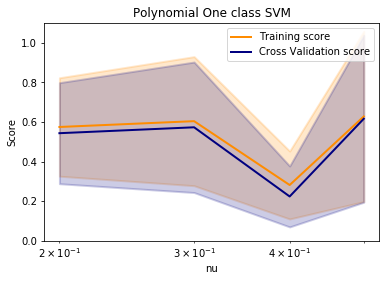

In [123]:
polySVM=OneClassSVM(kernel='poly',random_state=10)
param="nu"
param_range=[.2,.3,.4,.5]
plotValidationCurve(polySVM,"Polynomial One class SVM",train23GramFS,y,param,param_range,None,"accuracy",1)

#### Analysis:
* Training with both 2 and 3 grams has increased our accuracy
* Inference can be made that nu ~ .3 gives best performance
* Trying grid search to tune hyperparameters nu and gamma

#### Tuning more hyperparameters using Grid Search

* Trying Grid Search to find best poly kernel parameters

In [305]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {"kernel":('linear','poly','rbf'),'nu':[.23,.30,.50,.60],'gamma':np.logspace(-3,3,7)}
grid=GridSearchCV(OneClassSVM(),param_grid=parameters,scoring='accuracy')
grid.fit(train23GramFS,y)

### Analysis:
* Since I have less computing power, models have taken too much time to train
* But we can see that from one validation plot of poly kernel svm with nu~.3 gives a very good performance
* Due to this computing power bottleneck I was not able to run the grid search to tune the parameters of the polySVM.
* **My approach**: 
    - To compute tokens for each name 
    - Get unique tokens for the entire corpus
    - Form embeddings for each name using this token
    - Using OneClassSVM model I can classify the names on test set
    - PolySVM with nu~.3 gave me good performance
    - was able to vary only one parameter due to less computing power of my laptop
* **Next Steps**:
    - To vary other parameters and plot validation curves
    - To perform grid search and find the most optimal parameters
    - Try the following kmeans algorithm with a correct number of clusters (can be done by checking metric for each cluster)
    - develop a threshold value using some heuristic
    - classify points based on this distance threshold from its assigned cluster

#### Trying kMeans and mixture models 

Intuition:
    * there seemed to be clusters of names when PCA(2 dimensions) was done
    * Can we find clusters of names which are very similar based on the 2gram or 3gram embeddings?

In [96]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import pylab as pl
from sklearn.metrics import accuracy_score

In [97]:
#Two Gramnum=1s Model

In [98]:
class kMeansData:
    def __init__(self,data):
        self.data=data
        l=len(data)
        self.y=[1 for y in range(l)]

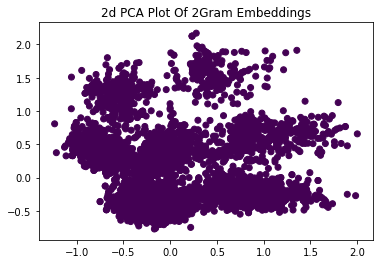

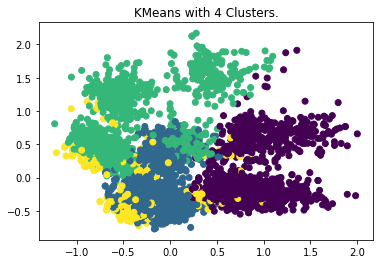

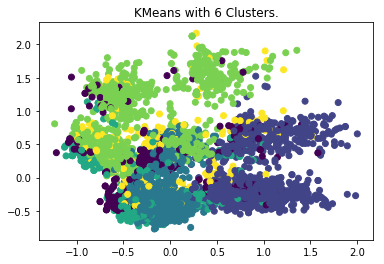

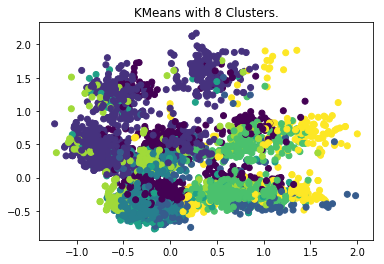

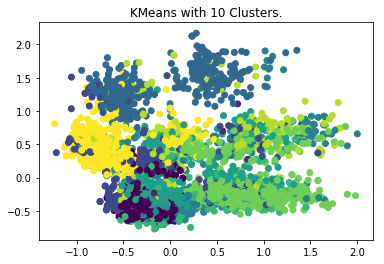

In [101]:
n_clusters=[4,6,8,10]
cKMeansObj=kMeansData(train23GramFS)
fignum=1
pcaKMeans=PCA(n_components=2).fit(cKMeansObj.data)
pca_2d=pcaKMeans.transform(cKMeansObj.data)
    
pl.figure('Reference Plot')
pl.scatter(pca_2d[:,0],pca_2d[:,1],c=cKMeansObj.y)
pl.title("2d PCA Plot Of 2Gram Embeddings")
pl.show()
for i in n_clusters:
    kMModel=KMeans(i,init='k-means++',n_init=10,max_iter=400)
    kmeans=kMModel.fit(train23GramFS)
    pl.figure("KMeans with "+str(i)+" Clusters")
    pl.scatter(pca_2d[:,0],pca_2d[:,1],c=kmeans.labels_)
    pl.title("KMeans with "+str(i)+" Clusters.")
    pl.show()
    fignum+=1 